In [10]:
import os
import cv2
import numpy as np
import trimesh
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.utils import save_image, make_grid
from utils.people_snapshot_dataset import People_Snapshot_Dataset
from utils.multi_garment_dataset import Multi_Garment_Dataset
from models.networks.smpl import SMPL
from models.networks.render import SMPLRenderer
from utils.util import load_obj, load_pickle_file, write_pickle_file

In [11]:
data_root = 'data/Multi-Garment_dataset'
pose_cam_path = 'assets/pose_cam.pkl'
isHres = True
image_size = 256
batch_size = 1
num_frame = 4

In [12]:
smpl = SMPL(pkl_path='assets/smpl_model.pkl', isHres=isHres).cuda()
if isHres:
    faces = smpl.faces_hres
else:
    faces = smpl.faces
smpl_render = SMPLRenderer(faces=faces).cuda()

In [13]:
train_dataset = Multi_Garment_Dataset(data_root=data_root, pose_cam_path=pose_cam_path, num_frame=num_frame, isHres=isHres)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [14]:
for i, data in enumerate(train_loader):
    for key in data:
        print(key, data[key].size())
    shape = data['shape'].cuda()
    pose = data['poses'][:, 0, :].cuda()
    cam = data['cams'][:, 0, :].cuda()
    v_personal = data['v_personal'].cuda()
    uv_image = data['uv_image'].cuda()
    f2vts = data['f2vts'].cuda()
    if i >= 0:
        break

shape torch.Size([1, 10])
poses torch.Size([1, 4, 72])
cams torch.Size([1, 4, 3])
v_personal torch.Size([1, 27554, 3])
uv_image torch.Size([1, 3, 2048, 2048])
f2vts torch.Size([1, 55104, 3, 2])


In [15]:
tex = smpl_render.extract_tex(uv_image, smpl_render.points_to_sampler(f2vts))
print(tex.size())

torch.Size([1, 55104, 3, 3, 3, 3])


In [16]:
verts = smpl(shape, pose, v_personal)
verts = smpl_render.project_to_image(verts, cam, flip=True, withz=True)

In [17]:
img_masked = smpl_render.render(verts, tex)
print(img_masked.size())

torch.Size([1, 3, 256, 256])


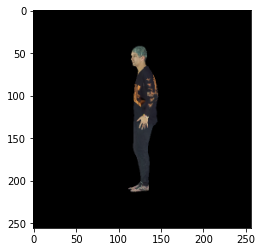

In [18]:
img_masked_vis = (img_masked.detach().cpu().numpy()[0] * 255).astype(np.uint8).transpose(1, 2, 0)
plt.imshow(img_masked_vis)